# Dimensionality reduction
We deal with Dimensionality Reduction (for instance PCA).

Import the needed Python packages.

In [ ]:
!pip install --upgrade --no-cache-dir gdown
from bs4 import BeautifulSoup
import pandas as pd
import nltk, numpy as np
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from gensim import corpora
from gensim.models import LsiModel, TfidfModel
from gensim.models.coherencemodel import CoherenceModel
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


The data we need to process comes from the book *Le Morte D'Arthur* by Thomas Malory.

We have to carry out __Topic Modeling__ on book chapters.

The goal is to achieve a topic division within the following limits:

- The total computation may not exceed 10 minutes (starting from Part 1.5; Parts 1.1 to 1.4 are not considered for time calculation)
- The division into topics must be the "best one"

### 1.1
Download the data from the Drive link (code already provided).

In [ ]:
!gdown 1zHgvidy9FvhZvE68S0mXWkoF-hHMpiUL
!gdown 1VjpTkFcbfaLIi4TXVafokW9e_bvGnfut

Downloading...
From: https://drive.google.com/uc?id=1zHgvidy9FvhZvE68S0mXWkoF-hHMpiUL
To: /content/The Project Gutenberg eBook of Le Morte D’Arthur, Volume I (of II), by Thomas Malory.html
100% 964k/964k [00:00<00:00, 479MB/s]
Downloading...
From: https://drive.google.com/uc?id=1VjpTkFcbfaLIi4TXVafokW9e_bvGnfut
To: /content/The Project Gutenberg eBook of Le Morte D’Arthur, Volume II (of II), by Thomas Malory.html
100% 1.10M/1.10M [00:00<00:00, 605MB/s]


### 1.2
Parse the HTML.


In [ ]:
with open('The Project Gutenberg eBook of Le Morte D’Arthur, Volume I (of II), by Thomas Malory.html') as fp:
    vol1 = BeautifulSoup(fp, 'html.parser')
with open('The Project Gutenberg eBook of Le Morte D’Arthur, Volume II (of II), by Thomas Malory.html') as fp:
    vol2 = BeautifulSoup(fp, 'html.parser')

def clean_text(txt):
    words_to_put_space_before = [".",",",";",":","’","'"]
    words_to_lowercase = ["First","How","Some","Yet","Of","A","The","What","Fifth"]
    
    app = txt.replace("\n"," ")
    for word in words_to_put_space_before:
        app = app.replace(word," "+word)
    for word in words_to_lowercase:
        app = app.replace(word+" ",word.lower()+" ")
    return app.strip()

def parse_html(soup):
    titles = []
    texts = []
    for chapter in soup.find_all("h3"):
        chapter_title = chapter.text
        if "CHAPTER" in chapter_title:
            chapter_title = clean_text("".join(chapter_title.split(".")[1:]))
            titles.append(chapter_title)
            
            chapter_text = [p.text for p in chapter.findNextSiblings("p")]
            chapter_text = clean_text(" ".join(chapter_text))
            texts.append(chapter_text)
    return titles, texts

In [ ]:
#Extract all the chapters' titles and texts from the two volumes

titles1, texts1 = parse_html(vol1)

titles2, texts2 = parse_html(vol2)


#Transform the list into a pandas DataFrame.

df = pd.DataFrame({'title': titles1, 'text': texts1, 'vol': 1})

temp = pd.DataFrame({'title': titles2, 'text': texts2, 'vol': 2})

df = pd.concat([df, temp], ignore_index=True)

del temp

Print the last 8 rows of the DataFrame.

[comment]: <> (#SHOW_CELL#)

In [ ]:
display(df.tail(8))

,title,text,vol
495,how Sir Bedivere found him on the morrow dead ...,"Then was Sir Bedivere glad , and thither he we...",2
496,of the opinion of some men of the death of Kin...,yet some men say in many parts of England that...,2
497,how when Sir Lancelot heard of the death of Ki...,And when he heard in his country that Sir Mord...,2
498,how Sir Launcelot departed to seek the Queen G...,"Then came Sir Bors de Ganis , and said : My lo...",2
499,how Sir Launcelot came to the hermitage where ...,"But sithen I find you thus disposed , I ensure...",2
500,how Sir Launcelot went with his seven fellows ...,"Then Sir Launcelot rose up or day , and told t...",2
501,"how Sir Launcelot began to sicken , and after ...",Then Sir Launcelot never after ate but little ...,2
502,how Sir Ector found Sir Launcelot his brother ...,And when Sir Ector heard such noise and light ...,2


### 1.3
Extract character's names from the **titles** only.

In [ ]:
all_characters = set()
def extract_character_names_from_string(string_to_parse):
    special_tokens = ["of","the","le","a","de"]

    remember = ""
    last_is_special_token = False

    tokens = string_to_parse.split(" ")
    characters_found = set()
    for i,word in enumerate(tokens):
        if word[0].isupper() or (remember!="" and word in special_tokens):
            #word = word.replace("'s","").replace("’s","")
            last_is_special_token = False
            if remember!="":
                if word in special_tokens:
                    last_is_special_token = True
                remember = remember+" "+word
            else: remember = word
        else:
            if remember!="":
                if last_is_special_token:
                    for tok in special_tokens:
                        remember = remember.replace(" "+tok,"")
                characters_found.add(remember)
            remember = ""
            last_is_special_token = False
    return characters_found

#all_characters = set([x for x in all_characters if x[-2:]!="'s"])

In [ ]:
#Extract all characters' names
all_characters = set().union(*list(df.title.apply(extract_character_names_from_string)))
print(all_characters)

{'Morgan', 'Sir Lavaine', 'Garlon', 'Sir Gaheris', 'Maledisant', 'Mordred', 'Dagonet', 'Sangreal', 'La Cote Male Taile', 'Guenever', 'Uther Pendragon', 'Our Lord', 'Arthur', 'Siege Perilous', 'Alisander le Orphelin', 'Merlin', 'Astolat', 'Ban', 'La Beale Isoud', 'Joyous Isle', 'Sir Epinogris', 'Sir Percivale', 'Sir Carados', 'Lady Lionesse', 'Sir Sagramore le Desirous', 'Bors', 'England', 'King Pellinore', 'Gawaine', 'Sir Tristram de Liones', 'Wales', 'Sir Mordred', 'Elias', 'Queen Guenever', 'Helin le Blank', 'Winchester', 'Sir Bors', 'King of England', 'Sir Gareth', 'Red Knight', 'Sir Palomides', 'Christmas', 'Camelot', 'Sir Bleoberis', 'Queen Isoud', 'Ireland', 'Sir Amant', 'Boudwin', 'Sir Malgrin', 'Galahad', 'Sir Lamorak de Galis', 'Maimed King', 'Rome', 'Sir Lamorak', 'Tintagil', 'Alice', 'Maid of Astolat', 'King Mordrains', 'Almaine', 'Solomon', 'King Evelake', 'Sir Suppinabiles', 'Sir Uriens', 'Sir Galihodin', 'Sir Colgrevance', 'Beaumains', 'Sir Dinadan', 'Logris', 'Gaheris', 

Print the names of all the knights (i.e. characters with `Sir` in their name).

[comment]: <> (#SHOW_CELL#)

In [ ]:
for name in all_characters:
  if "Sir" in name:
    print(name)#

Sir Lavaine
Sir Gaheris
Sir Epinogris
Sir Percivale
Sir Carados
Sir Sagramore le Desirous
Sir Tristram de Liones
Sir Mordred
Sir Bors
Sir Gareth
Sir Palomides
Sir Bleoberis
Sir Amant
Sir Malgrin
Sir Lamorak de Galis
Sir Lamorak
Sir Suppinabiles
Sir Uriens
Sir Galihodin
Sir Colgrevance
Sir Dinadan
Sir Segwarides
Sir Beaumains
Sir Berluse
Sir Galahalt
Sir Anguish
Sir Accolon of Gaul
Sir Nabon
Sir Lancelot
Sir Ector
Sir Mador
Sir Agravaine
Sir Persant of Inde
Sir Turquine
Sir Tristram
Sir Brian
Sir Blamore
Sir Bliant
Sir Lionel
Sir Bedivere
Sir Launcelot
Sir Belliance
Sir Breunor
Sir Archade
Sir Breuse Saunce Pité
Sir Urre
Sir Dagonet
Sir Elias
Sir Frol
Sir Meliagrance
Sir Kay
Sir Uwaine
Sir Persant
Sir Sadok
Sir Aglovale
Sir Marhaus
Sir Pedivere
Sir Lanceor
Sir Gawaine
Sir Tor
Sir Meliagaunce
Sir Pervivale
Sir Safere
Sir Pelleas
Sir Galahad
Sir Alisander
Sir Accolon


### 1.4
Preprocess the data

> Consider only the titles

> Each document must be a list of terms

> Discard documents that have less than 10 (non-unique) words before the preprocessing (split by whitespace, ignore punctuation)

> After preprocessing, each document must be represented by at least 5 tokens



In [ ]:
def preprocessing(text: str, tokenizer, stopwords: set, lemmatizer, token_min_length: int = 1, min_length: int = 10):
  assert token_min_length >= 1, "'token_min_length' takes only values from 1 and on."

  # We tokenize the text with the passed tokenizer
  tokens = tokenizer.tokenize(text.lower())

  # We check if the number of non unique words is larger than min_length
  if len(tokens) >= min_length:
    # We remove all the stopwords 
    words =  list(filter(lambda w: w.lower() not in stopwords, tokens))

    # Remove words which length is smaller than the passed minimum token length
    if token_min_length>1:
      words = [token for token in words if len(token) >= token_min_length]

    # We perform the lemmatization
    result = [lemmatizer.lemmatize(word) for word in words]
  
  else:
    result = []

  return result


# We initialize the tokenizer, the stopwords and the lemmatizer
tokenizer = RegexpTokenizer(r'[a-z]+')
stop_words = set(stopwords.words('english') + stopwords.words('french'))
lemmatizer = WordNetLemmatizer()

# We perform the first proprocessing part
preprocessed = df.title.apply(lambda x: preprocessing(x, tokenizer, stop_words, lemmatizer))


# We discard the documents that not fit the requirements
min_unique_tokens = 5

preprocessed = preprocessed[preprocessed.apply(lambda x: len(set(x))) >= min_unique_tokens]

Print the documents where the (preprocessed) term `Bedivere` appears.

[comment]: <> (#SHOW_CELL#)

In [ ]:
# We preprocess the term Bedivere
prep_word = preprocessing('Bedivere', tokenizer, stop_words, lemmatizer, min_length=1).pop()

# We perform the requested search for the term
display(preprocessed[preprocessed.apply(lambda x: prep_word in x)])

495    [sir, bedivere, found, morrow, dead, hermitage...
Name: title, dtype: object

### 1.5
Build a dictionary of the terms in the documents.

In [ ]:
# We create the Dictionary using the gensim module
dictionary = corpora.Dictionary(preprocessed)

# Init the inverted index as a defaultdict
inverted_index = defaultdict(list)

# Iterate over the documents
for document_id, terms in preprocessed.items():
    # Build the posting list for each term in our vocabulary
    for term in terms:
        inverted_index[dictionary.token2id[term]].append(document_id)

# The inverted index will have as keys the term id of the terms in the gensim dictionary 
# and as values the posting list with the documents id.
print(dict(inverted_index))

{3: [0, 8, 57, 162, 223, 433], 8: [0, 1], 5: [0, 1, 203], 6: [0, 26, 94, 95, 144, 156, 172, 187, 204, 212, 249, 293, 481, 487], 2: [0, 1, 84, 85], 0: [0, 1, 33, 157, 158, 165, 208, 215, 231, 259, 263], 4: [0, 20], 9: [0, 46, 117, 166, 191, 245, 261, 270, 412, 476, 490], 1: [0, 361, 398], 7: [0], 14: [1, 6, 10, 23, 33, 49, 63, 65, 74, 85, 106, 111, 121, 130, 135, 136, 153, 158, 163, 192, 203, 203, 214, 229, 243, 259, 260, 264, 265, 268, 268, 271, 322, 330, 335, 339, 353, 361, 364, 365, 373, 428, 429, 431, 432, 435, 467, 479, 485, 486, 489, 496], 17: [1, 8, 9, 13, 62, 189, 265, 477, 486, 489], 15: [1, 24, 83, 104, 184, 198, 275], 16: [1, 9, 19, 23, 24, 34, 35, 36, 37, 42, 45, 61, 375], 13: [1, 59, 167, 264, 268, 296, 419, 460], 11: [1], 12: [1, 24, 41, 58, 86, 115, 122, 352, 362, 378], 10: [1, 4, 4, 6, 7, 8, 9, 10, 11, 13, 17, 18, 19, 19, 20, 22, 22, 23, 24, 25, 25, 35, 36, 38, 46, 48, 50, 58, 62, 62, 63, 64, 66, 67, 68, 70, 71, 72, 74, 75, 76, 89, 90, 91, 92, 94, 96, 97, 100, 118, 119, 

Print out the 5 most common terms

[comment]: <> (#SHOW_CELL#)

In [ ]:
# We print the first 5 most common terms, considering common as the number of documents each term appears in.
# Mapping back from the term id to the term string
print([dictionary[termid] for termid in sorted(inverted_index,
                                               key=lambda x: len(inverted_index[x]),
                                               reverse=True)[0:5]])

['sir', 'king', 'launcelot', 'tristram', 'knight']


### 1.6
Perform a document-term encoding of the dataset.

In [ ]:
# Converting list of documents (corpus) into Document Term Matrix using dictionary.
doc_term_matrix = [dictionary.doc2bow(doc, allow_update=True) for doc in preprocessed]

# We set the smartirs parameter as weighting model that considers:
# - raw term frequency -> n
# - zero-corrected idf -> t
# - cosine method for document normalization -> c
doc_term_matrix_tfidf = list(TfidfModel(doc_term_matrix, smartirs='ntc')[doc_term_matrix])

Print out the sparsity of the matrix

[comment]: <> (#SHOW_CELL#)

In [ ]:
non_zero_elements = sum([len(elem) for elem in doc_term_matrix_tfidf])

n_terms = len(dictionary)
n_docs = len(preprocessed)
# Evaluate the rate of non zero elements over the Incidence Matrix dimension
density = non_zero_elements / (n_terms*n_docs)
print(f"The sparsity is {1 - density}")

The sparsity is 0.9902514622806579


### 1.7
Perform Latent Semantic Analysis for at least 5 different numbers of topics.

In [ ]:
seed = 160

# Init a possible of range of numbers of topic
numbers_of_topics = list(range(5, 31))

# Build an LSI Model for each possible number of topics
lsa_models = {}
for num_topics in tqdm(numbers_of_topics):
  lsa_models[num_topics] = LsiModel(doc_term_matrix_tfidf,
                                    num_topics=num_topics,
                                    id2word=dictionary,
                                    random_seed=seed)

  0%|          | 0/26 [00:00<?, ?it/s]

### 1.8
For each of the calculations above, calculate a measure of the "goodness" of the division into topics.

In [ ]:
metrics = ['c_v', 'c_npmi']
# Build the dictionary with the coherence scores and the numbers of topics
coherence_scores = defaultdict(list)
for num_topics in tqdm(numbers_of_topics):
  for metric in metrics:
    coherence_model = CoherenceModel(model=lsa_models[num_topics], texts=preprocessed, dictionary=dictionary, coherence=metric)
    coherence_scores[metric].append(coherence_model.get_coherence())

# Add the numbers of topics
coherence_scores['num_topics'] = numbers_of_topics

# Convert the dictionary in a dataframe for the Seaborn plots
goodness_measures = pd.DataFrame(coherence_scores)

# We performe the pd.melt method to obtain the needed df for the plots
goodness_measures = pd.melt(goodness_measures, id_vars=['num_topics'], value_vars=metrics, var_name='Metric', value_name='Goodness Score')

  0%|          | 0/26 [00:00<?, ?it/s]

Plot the measure as the number of topics varies.

[comment]: <> (#SHOW_CELL#)

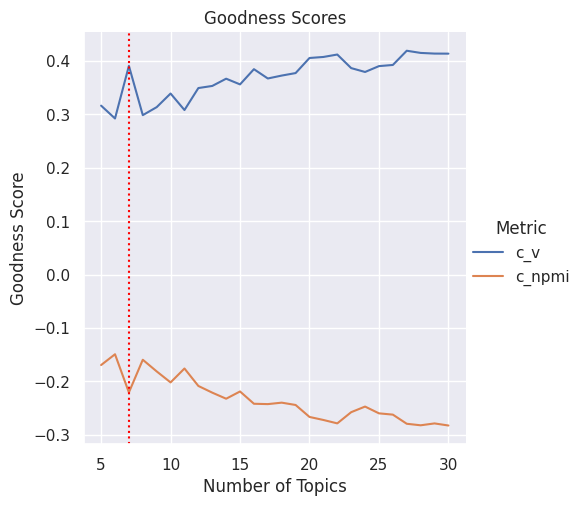

In [ ]:
sns.set()
plot = sns.relplot(data=goodness_measures, x="num_topics", y="Goodness Score",
                   hue="Metric", kind="line")
plot.set(title="Goodness Scores", xlabel="Number of Topics")
plt.axvline(x=7, c="red", linestyle="dotted")
plt.show()

# Notice that:
# - The c_npmi (normalized pointwise mutual information) method measures the degree of association between
#   two words in a topic by considering the frequency of co-occurrence of the two words in the corpus,
#   and comparing it to the frequency of occurrence of the individual words.
# - The c_v (coherence value) method measures the degree of semantic similarity
#   between words in a topic by considering their co-occurrence in a small window of text

Which number of topics is the "best" to model this dataset?

[comment]: <> (#SHOW_CELL#)

The 'c_npmi' method tends to favor models with a smaller number of well-defined topics, on the other hand, the 'c_v' method tends to favor models with a larger number of coherent topics.

We note that the trend in both curves indicates better goodness as the number of topics increases, but we choose to stop at the second peak (# topics = 7 for both the curves) since we want to avoid too specificity for our topics and we are aware of the trade-off between higher differentiability and significance of the results.

### 1.9
Print the 10 most important words for the 5 most important topics.

Topic number 0 has as top10 words: ['tristram', 'king', 'palomides', 'sir', 'launcelot', 'knight', 'arthur', 'came', 'mark', 'fought']

Topic number 1 has as top10 words: ['tristram', 'palomides', 'arthur', 'isoud', 'king', 'beale', 'knight', 'smote', 'made', 'bors']

Topic number 5 has as top10 words: ['queen', 'made', 'met', 'launcelot', 'round', 'table', 'knight', 'bors', 'lionel', 'slain']

Topic number 4 has as top10 words: ['isoud', 'beale', 'palomides', 'jousted', 'launcelot', 'fought', 'arthur', 'lady', 'smote', 'knight']

Topic number 3 has as top10 words: ['knight', 'jousted', 'launcelot', 'galahad', 'bors', 'queen', 'two', 'percivale', 'isoud', 'mark']



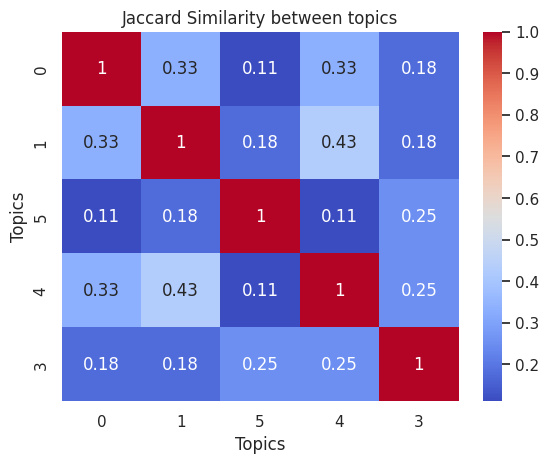

In [ ]:
optimal_num_topics = 7; best_5 = 5
# Get the coherence for each topic
coherence_model = CoherenceModel(model=lsa_models[optimal_num_topics], texts=preprocessed, dictionary=dictionary, coherence='c_v')
coherence_values = coherence_model.get_coherence_per_topic()
# Sort the topics to get the best 5
top_5_topics = sorted(range(len(coherence_values)), key=lambda i: coherence_values[i], reverse=True)[:best_5]
words = {}
for topic_idx in top_5_topics: # Print the 10 most important words for each of the top 5 topics
    words[topic_idx] = [word for word, _ in lsa_models[optimal_num_topics].show_topic(topic_idx, topn=10)]
    print(f"Topic number {topic_idx} has as top10 words: {words[topic_idx]}")
    print()
matrix = np.zeros((best_5, best_5))
for i, w1 in enumerate(words):
  for j, w2 in enumerate(words):
    matrix[i, j] = len(set(words[w1]).intersection(words[w2])) / len(set(words[w1]).union(words[w2]))
sns.heatmap(matrix, cmap='coolwarm', annot=True, xticklabels=top_5_topics, yticklabels=top_5_topics).set(title="Jaccard Similarity between topics", xlabel="Topics", ylabel="Topics")
plt.show()

Explain how we selected the 5 most important topics.

[comment]: <> (#SHOW_CELL#)


After Latent Semantic Analysis we sorted the topics by Coherence score (measured with "c_v" score) and then we selected the top 5.


We have also reported a heatmap with the Jaccard similairity between the word sets in each topic pair: it is noticeable that topic 5 particularly stands out because it is perhaps the only one entirely related to the concept of chivalry and the round table, topic 3 on the other hand is the only one that differs in that it is not inherent to the concept of fighting but to the family relationship between pairs of characters. Topics 1 and 4 are quite similar and inherent to the concept of love struggle, and topic 3 also resembles 1 because it is about actual fight in terms of pure action.



### 1.10
Suppose to have a dataset with $N$ samples and $M$ features.

We only have $B$ units of memory available on our storage medium.

Assume further that each feature occupies a constant number $b$ of memory units and that this cannot be changed (e.g. we cannot change the precision of floats).

Assuming that the entire dataset cannot fit on our storage medium, how would we accommodate all N samples while retaining as much information about our data as possible?


First, we define a first constraint which represents the maximum number of columns of the new reduced (in dimensionality) design matrix: $$N(M^\star \cdot b) \leq B \iff M^\star \leq \left\lfloor\frac {B}{N \cdot b}\right\rfloor$$ 

In view of this we perform a PCA (Principal Component Analysis) to obtain a new design matrix ($X^\star$) that respects the requested dimensionality ($N \times M^\star$) and that (by definition of PCA) holds the maximum percentage of the variance.

We take the first $M^\star$ eigenvalues of the matrix $X^tX$ (where $X$ is the original design matrix) and we derive the corresponding matrix of eigenvectors $E$ in order to derive a new reduced matrix $X^\star = XE$ , which holds the following percentage of information (variance): $$\frac {\sum_{i=1}^{M^\star} (\text{eigenval}_i(X^tX))^2} {\sum_{i=1}^{M} (\text{eigenval}_i(X^tX))^2}$$


<div style="page-break-after: always; visibility: hidden">
\pagebreak
</div>